In [2]:
# !pip install virtualenv
# !pip install virtualenvwrapper
# !virtual level0example
# !source level0exaple/bin/activate
# !pip install pandas
# !pip install scikit-learn
# !pip install lightgbm
# !pip install ipykernel
# !python -m ipykernel install -user --name=level0example

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sagemaker
import joblib
import os, boto3

In [5]:
import logging
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, average_precision_score, brier_score_loss, fbeta_score, \
    confusion_matrix, classification_report, roc_curve, auc

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [6]:
import lightgbm as lgb

# Data Preprocessing

In [8]:
# In this example, the data source is a csv file for the convenience, but in the actual application, 
# it should be more established data source such as RDS.
df = pd.read_csv('./dataset/large/churn-dataset.csv')
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,...,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,...,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,...,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,...,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,...,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


In [47]:
model_data

,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,...,Area Code_866,Area Code_868,Area Code_876,Area Code_877,Area Code_878,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes,Churn?_True.
0,163,300,8.162204,3,3.933035,4,4.065759,100,4.928160,6,...,0,0,0,0,0,1,0,0,1,1
1,15,0,10.018993,4,2.325005,0,7.141040,200,3.221748,6,...,0,0,0,0,0,0,1,1,0,0
2,131,300,4.708490,3,4.537466,3,5.363235,100,7.139023,2,...,0,0,0,0,0,1,0,0,1,0
3,75,700,1.268734,3,2.528748,5,3.773586,450,2.245779,6,...,0,0,0,0,1,0,1,0,1,0
4,146,0,2.696177,3,6.015337,3,3.751673,250,6.905545,4,...,0,0,0,0,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4,800,10.862632,5,6.936164,1,4.921314,350,4.872570,8,...,0,0,0,0,0,0,1,0,1,0
4996,140,0,1.581127,8,7.377591,7,0.939932,300,6.938571,2,...,0,0,0,0,0,1,0,1,0,0
4997,32,700,0.163836,5,5.841852,3,0.939469,450,4.388328,7,...,0,0,0,0,0,1,0,0,1,0
4998,142,600,2.034454,5,4.140554,3,6.076043,150,7.173376,3,...,0,0,0,0,0,0,1,0,1,1


In [79]:
def preprocess(path):
    df = pd.read_csv(path)
    # drop the "Phone" feature column
    df = df.drop(["Phone"], axis=1)

    # Change the data type of "Area Code"
    df["Area Code"] = df["Area Code"].astype(object)

    # Drop several other columns
    df = df.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

    # Convert categorical variables into dummy/indicator variables.
    model_data = pd.get_dummies(df)
    model_data.columns = [c.lower().replace(' ','_') for c in model_data.columns]

    # Create one binary classification target column
    # In case the original data does not have "Churn?" column, do try-except.
    try:
        X = model_data.drop(["churn?_false.", "churn?_true."], axis=1)
        y = model_data["churn?_true."]    
        model_data = pd.concat([X, y], axis=1,)
    except:
        X = model_data
        y = pd.Series(np.array([np.nan]*X.shape[0]))

    return X, y

In [80]:
# # drop the "Phone" feature column
# df = df.drop(["Phone"], axis=1)

# # Change the data type of "Area Code"
# df["Area Code"] = df["Area Code"].astype(object)

# # Drop several other columns
# df = df.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

# # Convert categorical variables into dummy/indicator variables.
# model_data = pd.get_dummies(df)

# # Create one binary classification target column
# # In case the original data does not have "Churn?" column, do try-except.
# try:
#     X = model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)
#     y = model_data["Churn?_True."]    
#     model_data = pd.concat([X, y], axis=1,)
# except:
#     X = model_data
#     y = pd.Series(np.array([np.nan]*X.shape[0]))

X, y = preprocess('./dataset/large/churn-dataset.csv')


# Split the data
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size=0.2, random_state=1111, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.1, random_state=1112, stratify=y_train0)

In [81]:
X_train0.head()

,account_length,vmail_message,day_mins,day_calls,eve_mins,eve_calls,night_mins,night_calls,intl_mins,intl_calls,...,area_code_858,area_code_866,area_code_868,area_code_876,area_code_877,area_code_878,int'l_plan_no,int'l_plan_yes,vmail_plan_no,vmail_plan_yes
2165,72,0,0.961002,4,4.081074,2,3.425513,450,6.182405,8,...,0,0,0,0,0,0,1,0,1,0
1472,128,600,7.360861,4,6.433208,0,2.486742,250,4.646720,7,...,0,0,0,0,0,0,1,0,0,1
4681,176,0,4.183882,3,2.087975,8,2.526671,300,5.956726,3,...,0,0,1,0,0,0,1,0,1,0
2696,167,0,1.356692,2,6.041963,3,4.807480,350,4.437733,6,...,0,0,0,0,0,0,1,0,1,0
4939,48,500,6.045495,2,7.186290,0,3.196127,250,2.645044,7,...,0,0,0,0,0,0,1,0,0,1


In [82]:
print(y_train.sum()/X_train.shape[0])
print(y_val.sum()/X_val.shape[0])
print(y_test.sum()/X_test.shape[0])

0.49944444444444447
0.5
0.5


# Model Training

In [83]:
clf = lgb.LGBMClassifier(
    boosting_type='gbdt', 
    colsample_bytree=0.4, 
    learning_rate=0.05,
    min_data_in_leaf=53, 
    min_split_gain=0.4, 
    n_estimators=75, 
    num_leaves=38, 
    objective='binary',
    seed=500, 
    subsample=0.8,
    class_weight='balanced',
    metric='binary_logloss',
    random_state=2222
)

In [84]:
clf.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='logloss',
        early_stopping_rounds=100)

[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] seed is set=500, random_state=2222 will be ignored. Current value: seed=500
[1]	valid_0's binary_logloss: 0.666016
[2]	valid_0's binary_logloss: 0.648522
[3]	valid_0's binary_logloss: 0.629188
[4]	valid_0's binary_logloss: 0.609431
[5]	valid_0's binary_logloss: 0.598459
[6]	valid_0's binary_logloss: 0.578537
[7]	valid_0's binary_logloss: 0.578426
[8]	valid_0's binary_logloss: 0.563653
[9]	valid_0's binary_logloss: 0.545211
[10]	valid_0's binary_logloss: 0.537009
[11]	valid_0's binary_logloss: 0.521897
[12]	valid_0's binary_logloss: 0.506204
[13]	valid_0's binary_logloss: 0.496997
[14]	valid_0's binary_logloss: 0.487086
[15]	valid_0's binary_logloss: 0.472746
[16]	valid_0's binary_logloss: 0.46573
[17]	valid_0's binary_logloss: 0.462617
[18]	valid_0's binary_logloss: 0.455222
[19]	valid_0's binary_logloss: 0.446648
[20]	valid_0's binary_logloss: 

/home/ec2-user/level0example/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(class_weight='balanced', colsample_bytree=0.4,
               learning_rate=0.05, metric='binary_logloss', min_data_in_leaf=53,
               min_split_gain=0.4, n_estimators=75, num_leaves=38,
               objective='binary', random_state=2222, seed=500, subsample=0.8)

In [85]:
print('Training AUC is {0:.3f}'.format(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])))

print('Testing f1 score is {0:.3f}'.format(f1_score(y_test, clf.predict(X_test))))
print('Testing precision is {0:.3f}'.format(precision_score(y_test, clf.predict(X_test))))
print('Testing recall is {0:.3f}'.format(recall_score(y_test, clf.predict(X_test))))
print('Testing AUC is {0:.3f}'.format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))
print('Testing Confusion matrix: \n {0}'.format(confusion_matrix(y_test, clf.predict(X_test)))) 

Training AUC is 0.989
Testing f1 score is 0.914
Testing precision is 0.901
Testing recall is 0.928
Testing AUC is 0.972
Testing Confusion matrix: 
 [[449  51]
 [ 36 464]]


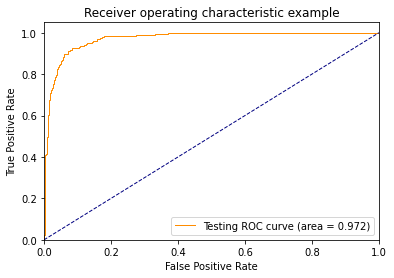

In [86]:
fpr = dict()
tpr = dict()
threshold = dict()
roc_auc = dict()
for i in range(1,2):
    fpr[i], tpr[i], threshold[i] = roc_curve(abs(y_test-abs(i-1)),clf.predict_proba(X_test)[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=1, label='Testing ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [87]:
# dump the model locally.
joblib.dump(clf,'clf.joblib')

['clf.joblib']

In [88]:
# dump the model to S3
sess = sagemaker.Session()
boto3.resource('s3').meta.client.upload_file('clf.joblib',
                                    sess.default_bucket(),
                                    os.path.join('model-store','level0example', 'clf.joblib')
                                   )

# New data prediction

In [80]:
from io import BytesIO 
import os
import json
import pandas as pd
import numpy as np
import joblib
import lightgbm

with BytesIO() as f:
    boto3.resource('s3').meta.client.download_fileobj(Bucket=sess.default_bucket(), Key=os.path.join('model-store','level0example', 'clf.joblib'), Fileobj=f)
    f.seek(0)
    clf_loaded = joblib.load(f)
joblib.dump(clf_loaded,'clf_loaded.joblib')
clf_loaded

LGBMClassifier(class_weight='balanced', colsample_bytree=0.4,
               learning_rate=0.05, metric='binary_logloss', min_data_in_leaf=53,
               min_split_gain=0.4, n_estimators=75, num_leaves=38,
               objective='binary', random_state=2222, seed=500, subsample=0.8)

In [81]:
X_new, _ = preprocess('test.csv')
for c in clf_loaded.feature_name_:
    if np.isin(X_new.columns,c).sum()==0:
        X_new[c] = 0
X_new

,account_length,vmail_message,day_mins,day_calls,eve_mins,eve_calls,night_mins,night_calls,intl_mins,intl_calls,...,area_code_788,area_code_797,area_code_798,area_code_827,area_code_847,area_code_848,area_code_858,area_code_868,area_code_876,area_code_877
0,163,300,8.162204,3,3.933035,4,4.065759,100,4.928160,6,...,0,0,0,0,0,0,0,0,0,0
1,15,0,10.018993,4,2.325005,0,7.141040,200,3.221748,6,...,0,0,0,0,0,0,0,0,0,0
2,131,300,4.708490,3,4.537466,3,5.363235,100,7.139023,2,...,0,0,0,0,0,0,0,0,0,0
3,75,700,1.268734,3,2.528748,5,3.773586,450,2.245779,6,...,0,0,0,0,0,0,0,0,0,0
4,146,0,2.696177,3,6.015337,3,3.751673,250,6.905545,4,...,0,0,0,0,0,0,0,0,0,0
5,83,0,3.634776,7,6.051944,5,2.937880,300,4.948816,4,...,0,0,0,0,0,0,0,0,0,0
6,140,0,3.229420,4,2.440153,8,2.352274,300,5.393439,4,...,0,0,0,0,0,0,0,0,0,0
7,54,0,0.567920,6,4.507027,0,0.688785,400,5.012747,5,...,0,0,0,0,0,0,0,0,0,0
8,195,0,5.811116,6,8.104126,2,4.208352,250,4.750153,7,...,0,0,0,0,0,0,0,0,0,0
9,104,0,2.714430,7,8.529944,6,2.342177,300,3.433554,5,...,0,0,0,0,0,0,0,0,0,0


In [83]:
{
    'statusCode': 200,
    'body': json.dumps(list(clf_loaded.predict_proba(X_new)[:,1]))
}

{'statusCode': 200,
 'body': '[0.9127484066354039, 0.15763453640083774, 0.6441802976600883, 0.029416769282521307, 0.44826417768890314, 0.14488869452589898, 0.03972167119766155, 0.1820892667351903, 0.7108226690195896, 0.11587868902830595]'}

In [99]:
clf.predict_proba(X_train.iloc[X_train.index==1,:])

array([[0.84236546, 0.15763454]])